In [1]:
# Importing the required libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer

warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Importing the data in python environment.
train_raw = pd.read_csv("train.csv")
train = train_raw.copy()
test_raw = pd.read_csv("test.csv")
test = test_raw.copy()

In [3]:
train.head(3)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.00,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.00,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.25,64.0,121.0,8464,4


In [4]:
test.head(3)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681


In [5]:
# Finding target variable
for col in train.columns:
    if col not in test.columns:
        print('Target Variable is ',col)

Target Variable is  Target


As the test data is only for predictions , we'll have our all analysis on train data only.

In [6]:
train.shape

(9557, 143)

In [7]:
# Checking for missing values.
train.isnull().any().sum()

5

- We have 5 columns having missing values.

#### Missing Value Treatment

In [8]:
missing_cols = [x for x in train.columns if train[x].isnull().any()]
missing_cols

['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']

In [9]:
missing_cols_df = pd.DataFrame({'Columns':missing_cols,
                                '# Missing values' :[train[x].isnull().sum() for x in missing_cols]})

missing_cols_df['%'] = missing_cols_df['# Missing values'] / len(train) * 100
missing_cols_df['%'] = np.round(missing_cols_df['%'],2)
missing_cols_df

,Columns,# Missing values,%
0,v2a1,6860,71.78
1,v18q1,7342,76.82
2,rez_esc,7928,82.95
3,meaneduc,5,0.05
4,SQBmeaned,5,0.05


- For columns having more than 70% , we'll drop the column .
- For 2 columns having only 5 missing values, we can impute it with appropriate method.

In [10]:
train.drop(missing_cols[:3],axis=1,inplace=True)
train.shape

(9557, 140)

In [11]:
train['meaneduc'].describe()

count    9552.000000
mean        9.231523
std         4.167694
min         0.000000
25%         6.000000
50%         9.000000
75%        11.600000
max        37.000000
Name: meaneduc, dtype: float64

- The mean is nearly equal to median.
- We'll impute missing values with mean.

In [12]:
train['meaneduc'] = train['meaneduc'].fillna(value=train.meaneduc.mean())
train['meaneduc'].isnull().sum()

0

In [13]:
train['SQBmeaned'].describe()

count    9552.000000
mean      102.588867
std        93.516890
min         0.000000
25%        36.000000
50%        81.000000
75%       134.560010
max      1369.000000
Name: SQBmeaned, dtype: float64

- The mean is greater than median ,suggesting right skewd distribution.
- We'll impute missing values with median.

In [14]:
train['SQBmeaned'] = train['SQBmeaned'].fillna(value=train.SQBmeaned.median())
train['SQBmeaned'].isnull().sum()

0

In [15]:
train.isnull().sum().sum()

0

- Now we have no missing values.

#### Data Types Analysis

In [16]:
train.dtypes.unique()

array([dtype('O'), dtype('int64'), dtype('float64')], dtype=object)

In [17]:
dtypes_df = pd.DataFrame({'Data Types':train.dtypes.unique(),
                          '# of Columns': [sum(train.dtypes==x) for x in train.dtypes.unique()]})
dtypes_df

,Data Types,# of Columns
0,object,5
1,int64,130
2,float64,5


- The object data types needs to represented as numbers for machine learning.
- Let's analyse these columns first.

In [18]:
# String Columns.
train.describe(include='object')

,Id,idhogar,dependency,edjefe,edjefa
count,9557,9557,9557,9557,9557
unique,9557,2988,31,22,22
top,ID_279628684,fd8a6d014,yes,no,no
freq,1,13,2192,3762,6230


- Id is unique for every record,it'll add no value to our analysis.
- We'll drop Id from datasets.

In [19]:
train.drop('Id',axis=1,inplace=True)
train.shape

(9557, 139)

In [20]:
train['idhogar'][:5]

0    21eb7fcc1
1    0e5d7a658
2    2c7317ea8
3    2b58d945f
4    2b58d945f
Name: idhogar, dtype: object

In [21]:
train['idhogar'].apply(lambda x : x[0]).unique()

array(['2', '0', 'd', 'b', 'c', '6', 'e', '3', '1', '7', 'f', '9', 'a',
       '5', '8', '4'], dtype=object)

- The values are all  of nominal categorical data type and 2988 unique values.
- There doesn't seem to be any pattern.
- we'll drop it.

In [22]:
train.drop('idhogar',axis=1,inplace=True)
train.shape

(9557, 138)

In [23]:
train['dependency'].unique()

array(['no', '8', 'yes', '3', '.5', '.25', '2', '.66666669', '.33333334',
       '1.5', '.40000001', '.75', '1.25', '.2', '2.5', '1.2', '4',
       '1.3333334', '2.25', '.22222222', '5', '.83333331', '.80000001',
       '6', '3.5', '1.6666666', '.2857143', '1.75', '.71428573',
       '.16666667', '.60000002'], dtype=object)

In [24]:
train['dependency'].value_counts(normalize=True)[:2] * 100

yes    22.936068
no     18.279795
Name: dependency, dtype: float64

- Yes and no seems to inappropriate for dependency variable which is actually a ratio.
- We'll simply map these string values.
- For no, 0 seems to be apt.
- For yes, we would simply assume 1.
- The values are also in string format we need to convert them to numbers.

In [25]:
def map_yes_no(val):
    if val == 'yes':
        return 1
    elif val == 'no':
        return 0
    else :
        return float(val)

In [26]:
train['dependency'] = train['dependency'].apply(map_yes_no)

In [27]:
train['dependency'].unique()

array([0.        , 8.        , 1.        , 3.        , 0.5       ,
       0.25      , 2.        , 0.66666669, 0.33333334, 1.5       ,
       0.40000001, 0.75      , 1.25      , 0.2       , 2.5       ,
       1.2       , 4.        , 1.3333334 , 2.25      , 0.22222222,
       5.        , 0.83333331, 0.80000001, 6.        , 3.5       ,
       1.6666666 , 0.2857143 , 1.75      , 0.71428573, 0.16666667,
       0.60000002])

In [28]:
train['edjefe'].unique(),train['edjefa'].unique()

(array(['10', '12', 'no', '11', '9', '15', '4', '6', '8', '17', '7', '16',
        '14', '5', '21', '2', '19', 'yes', '3', '18', '13', '20'],
       dtype=object),
 array(['no', '11', '4', '10', '9', '15', '7', '14', '13', '8', '17', '6',
        '5', '3', '16', '19', 'yes', '21', '12', '2', '20', '18'],
       dtype=object))

- Here also, there are yes and no.
- We'll map these values same as before.

In [29]:
train['edjefe'] = train['edjefe'].apply(map_yes_no)
train['edjefa'] = train['edjefa'].apply(map_yes_no)

In [30]:
train['edjefe'].unique()

array([10., 12.,  0., 11.,  9., 15.,  4.,  6.,  8., 17.,  7., 16., 14.,
        5., 21.,  2., 19.,  1.,  3., 18., 13., 20.])

In [31]:
train.describe(include='float')

,dependency,edjefe,edjefa,meaneduc,overcrowding,SQBovercrowding,SQBdependency,SQBmeaned
count,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000
mean,1.149550,5.096788,2.896830,9.231523,1.605380,3.249485,3.900409,102.577572
std,1.605993,5.246513,4.612056,4.166603,0.819946,4.129547,12.511831,93.493725
min,0.000000,0.000000,0.000000,0.000000,0.200000,0.040000,0.000000,0.000000
25%,0.333333,0.000000,0.000000,6.000000,1.000000,1.000000,0.111111,36.000000
50%,0.666667,6.000000,0.000000,9.000000,1.500000,2.250000,0.444444,81.000000
75%,1.333333,9.000000,6.000000,11.500000,2.000000,4.000000,1.777778,132.250000
max,8.000000,21.000000,21.000000,37.000000,6.000000,36.000000,64.000000,1369.000000


In [32]:
(train['dependency'] ** 2 == train['SQBdependency']).value_counts()

True     8119
False    1438
dtype: int64

In [33]:
(train['overcrowding'] ** 2 == train['SQBovercrowding']).value_counts()

True     6615
False    2942
dtype: int64

In [34]:
(train['meaneduc'] ** 2 == train['SQBmeaned']).value_counts()

True     7737
False    1820
dtype: int64

- We can see though from name and description it seems like some columns are squared but that is not true for every values.
- we'll keep them both as of now.

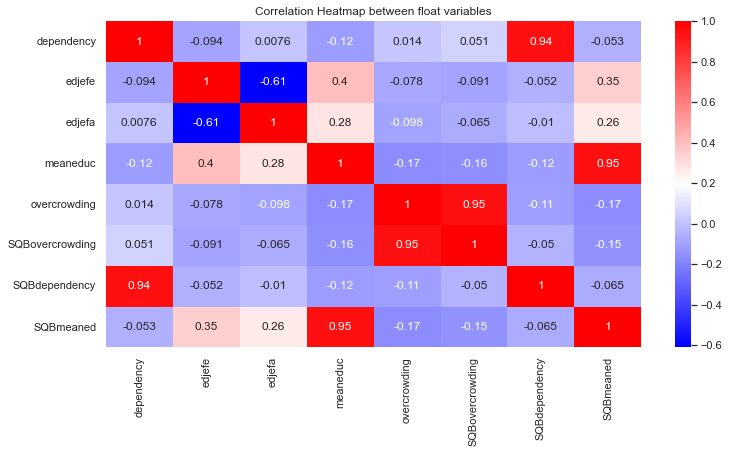

In [35]:
# Correlation Matrix of float variables.
plt.figure(figsize=(12,6))
sns.heatmap(train[train.describe(include='float').columns].corr(),cmap='bwr',annot=True)
plt.title('Correlation Heatmap between float variables')
plt.show()

- Except for edjefe and edjefa,all variables are strongly correlated.
- We might consider removing them.
- We'll do it in feature reduction.

In [36]:
train.describe(include='int')

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,agesq,Target
count,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000
mean,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,0.385895,1.559171,1.945066,0.399184,...,0.714555,0.285445,34.303547,74.222769,1643.774302,19.132887,53.500262,3.844826,1643.774302,3.302292
std,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.680779,1.036574,1.188852,0.692460,...,0.451650,0.451650,21.612261,76.777549,1741.197050,18.751395,78.445804,6.946296,1741.197050,1.009565
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,17.000000,16.000000,289.000000,9.000000,0.000000,0.000000,289.000000,3.000000
50%,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,...,1.000000,0.000000,31.000000,36.000000,961.000000,16.000000,36.000000,1.000000,961.000000,4.000000
75%,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,3.000000,1.000000,...,1.000000,1.000000,51.000000,121.000000,2601.000000,25.000000,81.000000,4.000000,2601.000000,4.000000
max,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,5.000000,8.000000,8.000000,6.000000,...,1.000000,1.000000,97.000000,441.000000,9409.000000,169.000000,441.000000,81.000000,9409.000000,4.000000


- It's very hard to analyse from above.

In [37]:
# Independent variables.
single_value_data = []
binary_data = []
multi_value_data = []
for i in train.drop('Target',axis=1):
    if train[i].nunique() == 1:
        single_value_data.append(i)
    elif train[i].nunique() == 2 :
        binary_data.append(i)  
    else:
        multi_value_data.append(i)
print('No of independent variables having only one value :'  ,len(single_value_data)) 
print('No of independent variables having binary values :',len(binary_data))
print('No of independent variables having multiple values :',len(multi_value_data))

No of independent variables having only one value : 1
No of independent variables having binary values : 101
No of independent variables having multiple values : 35


- there is one variable which has only single value and hence no variation.
- Most of the data comprimises of binary data that is about 101 features.

In [38]:
# For multiple unique values.
for i in multi_value_data:
    print(f'for {i},unique values = {train[i].nunique()}')

for rooms,unique values = 11
for r4h1,unique values = 6
for r4h2,unique values = 9
for r4h3,unique values = 9
for r4m1,unique values = 6
for r4m2,unique values = 7
for r4m3,unique values = 9
for r4t1,unique values = 7
for r4t2,unique values = 11
for r4t3,unique values = 13
for tamhog,unique values = 13
for tamviv,unique values = 14
for escolari,unique values = 22
for hhsize,unique values = 13
for hogar_nin,unique values = 10
for hogar_adul,unique values = 10
for hogar_mayor,unique values = 4
for hogar_total,unique values = 13
for dependency,unique values = 31
for edjefe,unique values = 22
for edjefa,unique values = 22
for meaneduc,unique values = 156
for bedrooms,unique values = 7
for overcrowding,unique values = 38
for qmobilephone,unique values = 11
for age,unique values = 97
for SQBescolari,unique values = 22
for SQBage,unique values = 97
for SQBhogar_total,unique values = 13
for SQBedjefe,unique values = 22
for SQBhogar_nin,unique values = 10
for SQBovercrowding,unique values = 38


- From above, it is clear that none of features have continous data.

#### Checking if there is a house without a family head.

In [39]:
train['parentesco1'].value_counts()

0    6584
1    2973
Name: parentesco1, dtype: int64

In [40]:
train['parentesco1'].value_counts(normalize=True)

0    0.688919
1    0.311081
Name: parentesco1, dtype: float64

In [41]:
train.groupby('Target')['parentesco1'].value_counts()

Target  parentesco1
1       0               533
        1               222
2       0              1155
        1               442
3       0               854
        1               355
4       0              4042
        1              1954
Name: parentesco1, dtype: int64

- There are about 31% of house without a family head.
- Majority of them belong to class 4.

#### Checking whether all members of the house have the same poverty level.

In [42]:
train_raw.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1).value_counts()

True     2903
False      85
Name: Target, dtype: int64

- There are 85 households where members of the house doesn't have the same poverty level.

#### Target Variable Analysis

In [43]:
train['Target'].unique()

array([4, 2, 3, 1], dtype=int64)

- There are 4 unique levels making it a classification problem.

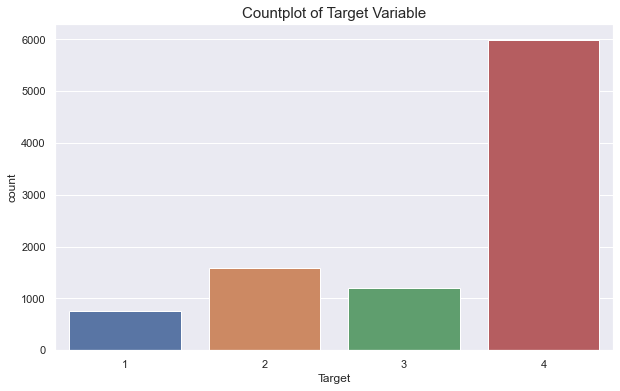

In [44]:
plt.figure(figsize=(10,6))
sns.countplot(x='Target',data=train)
plt.title('Countplot of Target Variable',size=15)
plt.show()

In [45]:
train['Target'].value_counts(normalize=True)

4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64

- The data is not balanced.
- 62% of data belongs to level 4.
- just 8% of data belongs to level 1.

#### Fetaure Reduction

In [46]:
train[single_value_data].var()

elimbasu5    0.0
dtype: float64

In [47]:
train['elimbasu5'].unique()

array([0], dtype=int64)

- There is only one value .
- This isn't going to add any value to our analysis, we'll drop it.

In [48]:
train.drop('elimbasu5',axis=1,inplace=True)
train.shape

(9557, 137)

In [49]:
features = train.drop('Target',axis=1)
target = train['Target']
features.shape

(9557, 136)

- There are now 136 features (excluding Target column).
- Let's have a look at perfectly correlated variables.

In [50]:
# Selecting the upper traingular matrix.
corr_matrix = features.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))
upper_tri

,hacdor,rooms,hacapo,v14a,refrig,v18q,r4h1,r4h2,r4h3,r4m1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
hacdor,NaN,-0.233369,0.652594,-0.175011,-0.101965,-0.084680,0.232508,0.059313,0.184857,0.268978,...,-0.118168,-0.109862,-0.102725,0.350546,-0.082229,0.388043,0.794699,0.005278,-0.099127,-0.102725
rooms,NaN,NaN,-0.213368,0.129183,0.130531,0.254256,-0.066578,0.267627,0.195222,-0.032558,...,0.077046,0.233679,0.068288,0.221595,0.198890,0.007952,-0.355526,-0.027575,0.249956,0.068288
hacapo,NaN,NaN,NaN,-0.150986,-0.124506,-0.067529,0.226378,0.126645,0.240056,0.241452,...,-0.087773,-0.092703,-0.075528,0.373720,-0.071170,0.367025,0.640096,0.014411,-0.103303,-0.075528
v14a,NaN,NaN,NaN,NaN,0.143143,0.036396,-0.054769,0.018133,-0.015552,-0.006370,...,0.027193,0.036483,0.023831,0.009100,0.018897,-0.015193,-0.174969,0.005712,0.034702,0.023831
refrig,NaN,NaN,NaN,NaN,NaN,0.086002,-0.047087,-0.022819,-0.046860,-0.023502,...,0.029801,0.097128,0.025846,-0.052195,0.082159,-0.108718,-0.123054,-0.034080,0.117378,0.025846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SQBhogar_nin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.477876,0.049113,-0.009583,-0.278921
SQBovercrowding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.049525,-0.150949,-0.218349
SQBdependency,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.065314,0.395814
SQBmeaned,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.112277


In [51]:
# Finding perfectly correlated values.
perfect_corr = {}

for i in upper_tri:
    perfect_corr[i] = []
    for pos,val in enumerate(upper_tri[i].values) :
        if val == 1 or val == -1:  
            correlated_column = corr_matrix.columns[pos]
            perfect_corr[i].append(correlated_column)
            
# Excluding empty values.
perfect_corr = {k:v for k,v in perfect_corr.items() if v }
perfect_corr

{'hhsize': ['tamhog'],
 'hogar_total': ['tamhog', 'hhsize'],
 'agesq': ['SQBage']}

 - We'll drop the perfectly correlated variables.

In [52]:
train.drop(['tamhog','hhsize','SQBage'],axis=1,inplace=True)
train.shape

(9557, 134)

In [53]:
# Finding strong relationship.
features = train.drop('Target',axis=1)
corr_matrix = features.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool))

strong_corr = {}

for i in upper_tri:
    strong_corr[i] = []
    for pos,val in enumerate(upper_tri[i].values):
        if val >= 0.9 or val <= -0.9:
            corr_col = corr_matrix.columns[pos]
            strong_corr[i].append(corr_col)
            
strong_corr = {k:v for k,v in strong_corr.items() if v}
strong_corr

{'tamviv': ['r4t3'],
 'abastaguafuera': ['abastaguadentro'],
 'coopele': ['public'],
 'sanitario3': ['sanitario2'],
 'energcocinar3': ['energcocinar2'],
 'female': ['male'],
 'hogar_total': ['r4t3', 'tamviv'],
 'area2': ['area1'],
 'SQBescolari': ['escolari'],
 'SQBhogar_total': ['r4t3', 'tamviv', 'hogar_total'],
 'SQBedjefe': ['edjefe'],
 'SQBovercrowding': ['overcrowding'],
 'SQBdependency': ['dependency'],
 'SQBmeaned': ['meaneduc'],
 'agesq': ['age']}

- The squared column of some values as expected have strong correlation with each other.
- We'll drop one of them.

In [54]:
cols_to_drop = []
for i in strong_corr.keys():
    for val in strong_corr[i]:
        cols_to_drop.append(val)
cols_to_drop = set(cols_to_drop)
print(cols_to_drop)

{'meaneduc', 'sanitario2', 'public', 'tamviv', 'escolari', 'r4t3', 'hogar_total', 'energcocinar2', 'male', 'overcrowding', 'edjefe', 'area1', 'age', 'dependency', 'abastaguadentro'}


In [55]:
train.drop(cols_to_drop,axis=1,inplace=True)
train.shape

(9557, 119)

Now for the binary data, it is very important to check if there are any biases.
- Let's suppose there are 90% of data belonging to one category.
- It wouldn't make sense to use these biased data as it is only going to confuse our model.

In [56]:
len(binary_data)

101

- As we have dropped some variables with perfect correlation.
- Let's redefine binary data and see if there are any biases.

In [57]:
binary_data = [x for x in binary_data if x in train.columns]
len(binary_data)

95

In [58]:
biased_cols = []
for col in binary_data:
    value_counts= np.round(train[col].value_counts(normalize=True),2)
    # Setting the thresolds to 90%.
    if value_counts[0] >= 0.9 or value_counts[1] >= 0.9:
        biased_cols.append(col)
len(biased_cols)        

58

- These 58 columns have one of values same for more than 90% records.
- These biased data could confuse the model.
- We'll drop these.

In [59]:
train.drop(biased_cols,axis=1,inplace=True)
train.shape

(9557, 61)

In [60]:
print(train.columns)

Index(['rooms', 'v18q', 'r4h1', 'r4h2', 'r4h3', 'r4m1', 'r4m2', 'r4m3', 'r4t1',
       'r4t2', 'paredblolad', 'paredpreb', 'paredmad', 'pisomoscer',
       'pisocemento', 'cielorazo', 'coopele', 'sanitario3', 'energcocinar3',
       'elimbasu1', 'epared2', 'epared3', 'etecho1', 'etecho2', 'etecho3',
       'eviv2', 'eviv3', 'female', 'estadocivil1', 'estadocivil2',
       'estadocivil3', 'estadocivil7', 'parentesco1', 'parentesco2',
       'parentesco3', 'hogar_nin', 'hogar_adul', 'hogar_mayor', 'edjefa',
       'instlevel1', 'instlevel2', 'instlevel3', 'instlevel4', 'instlevel5',
       'instlevel8', 'bedrooms', 'tipovivi1', 'tipovivi3', 'television',
       'qmobilephone', 'lugar1', 'area2', 'SQBescolari', 'SQBhogar_total',
       'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency',
       'SQBmeaned', 'agesq', 'Target'],
      dtype='object')


Now we have just 61 features after dropping redundant features and biased features.

#### Converting the data to numpy arrays.

In [61]:
features = train.drop('Target',axis=1)
target = train['Target']
X = features.to_numpy()
y = target.to_numpy()
X.shape,y.shape

((9557, 60), (9557,))

#### Splitting the data into train and test.

In [62]:
# Taking stratified sampling so that model could be evaluated in the same proportion as observed in data.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=1,stratify=y)
print ('Shape of training datasets ',X_train.shape,y_train.shape)
print ('Shape of testing datasets ',X_test.shape,y_test.shape)

Shape of training datasets  (7645, 60) (7645,)
Shape of testing datasets  (1912, 60) (1912,)


### Training the model

In [63]:
# Initialising the model
classifier = RandomForestClassifier(n_estimators=500,criterion='gini',n_jobs=-1,random_state=1,max_features=10)

In [64]:
pd.Series(y_train).value_counts()

4    4796
2    1278
3     967
1     604
dtype: int64

In [65]:
# Training the model
classifier.fit(X_train, y_train)

RandomForestClassifier(max_features=10, n_estimators=500, n_jobs=-1,
                       random_state=1)

In [66]:
# Predictions on test data.
preds = classifier.predict(X_test)
preds[:5]

array([4, 3, 4, 4, 3], dtype=int64)

In [67]:
# Classification result
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.98      0.85      0.91       151
           2       0.91      0.88      0.89       319
           3       0.97      0.80      0.88       242
           4       0.94      0.99      0.97      1200

    accuracy                           0.94      1912
   macro avg       0.95      0.88      0.91      1912
weighted avg       0.94      0.94      0.94      1912



In [68]:
accuracy_score(y_test, preds) * 100

93.93305439330544

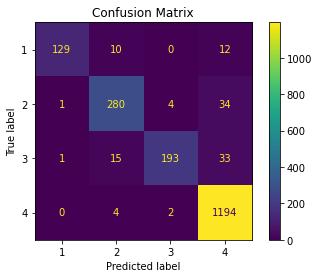

In [69]:
# Confusion Matrix
sns.reset_orig()
ConfusionMatrixDisplay.from_predictions(y_test,preds,labels = classifier.classes_)
plt.title('Confusion Matrix')
plt.show()

- We have got a very good accuracy score.
- The model has learnt very well for all classes.
- Due to max data points belonging to class 4 , it has maximum f1 score.

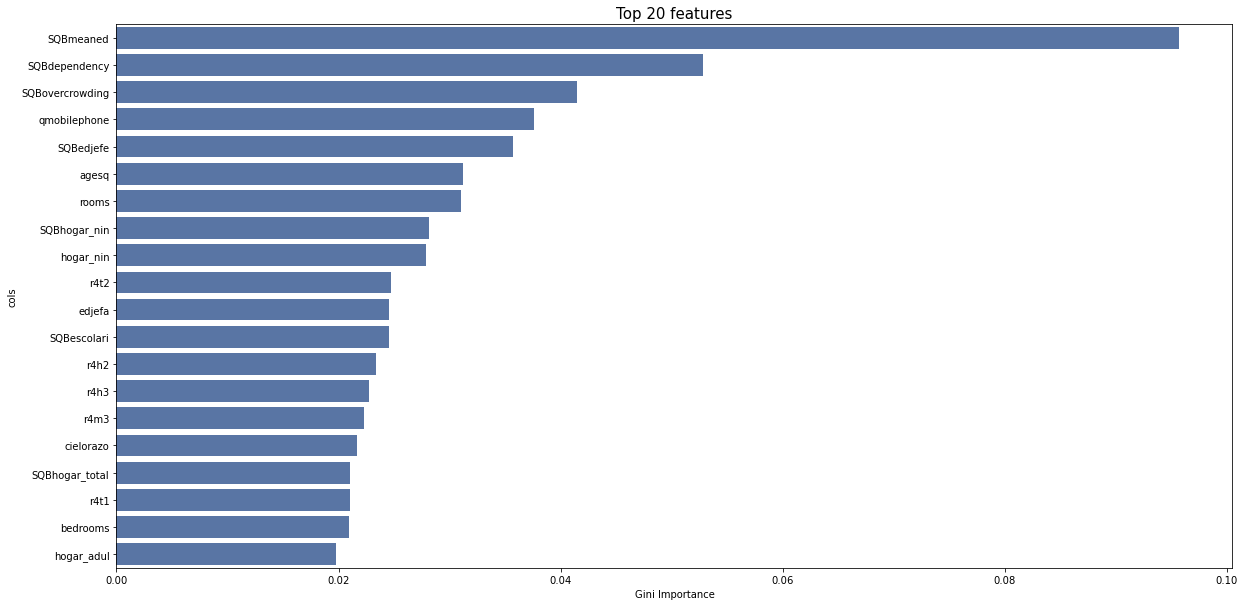

In [70]:
# Top 20 Features.
features_df = pd.DataFrame({'cols': features.columns,'Gini Importance': classifier.feature_importances_})
features_df.sort_values(by='Gini Importance',ascending=False,inplace=True)

plt.figure(figsize=(20,10))
sns.barplot(y='cols',x='Gini Importance',data=features_df[:20],color='b')
plt.title('Top 20 features', size=15)
plt.show()

### Cross Validation

- As our data is imbalanced, we'll use Stratified K-fold cross validation.

In [71]:
k_fold = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)

scores = []

i = 1

# Using whole datsets.
for train_index, test_index in k_fold.split(X,y):
    X_train_fold , X_test_fold = X[train_index], X[test_index]
    y_train_fold , y_test_fold = y[train_index], y[test_index]
    classifier.fit(X_train_fold, y_train_fold)
    accuracy_score = classifier.score(X_test_fold, y_test_fold)
    scores.append(accuracy_score)
    
    global i
    print(f'For iteration {i}, accuracy score is {accuracy_score}')
    i +=1

For iteration 1, accuracy score is 0.9518828451882845
For iteration 2, accuracy score is 0.944560669456067
For iteration 3, accuracy score is 0.9435146443514645
For iteration 4, accuracy score is 0.9424686192468619
For iteration 5, accuracy score is 0.9424686192468619
For iteration 6, accuracy score is 0.9361924686192469
For iteration 7, accuracy score is 0.948744769874477
For iteration 8, accuracy score is 0.949738219895288
For iteration 9, accuracy score is 0.9350785340314136
For iteration 10, accuracy score is 0.9486910994764398


In [72]:
print('Maximum Score = ',np.round(max(scores),2))
print('Minimum Score = ',np.round(min(scores),2))
print('Average Score  = ',np.round(np.mean(np.array(scores)),2))
print('Standard Deviation = ',np.round(np.std(np.array(scores)),2))

Maximum Score =  0.95
Minimum Score =  0.94
Average Score  =  0.94
Standard Deviation =  0.01


- The model performs well with a very less variation.

### Predictions on test data.

In [73]:
test_input = test[features.columns]
test_input.shape

(23856, 60)

In [74]:
# There is only one feature which needs mapping.
test_input['edjefa'] = test_input['edjefa'].apply(map_yes_no)

In [75]:
test_input.isnull().sum().sum()

31

In [76]:
missing_cols_test = [x for x in test_input.columns if test_input[x].isnull().any()]
missing_cols_test

['SQBmeaned']

In [77]:
test_input['SQBmeaned'].isnull().sum()

31

- For the missing values , we'll use knn imputations based on training data.

In [78]:
imputer = KNNImputer(n_neighbors=7)

In [79]:
model_input = imputer.fit_transform(test_input)

In [80]:
# Predictions.
test['Target'] = classifier.predict(model_input)
test.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,0,16,9,0,1,2.25,0.25,272.25,16,4
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,256,1681,9,0,1,2.25,0.25,272.25,1681,4
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,289,1681,9,0,1,2.25,0.25,272.25,1681,4
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,256,3481,1,256,0,1.00,0.00,256.00,3481,4
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,121,324,1,0,1,0.25,64.00,NaN,324,4


In [81]:
test['Target'].value_counts()

4    19024
2     3400
1      738
3      694
Name: Target, dtype: int64